# Evaluation

In [2]:
# Importing libraries
import torchio as tio
import glob
import numpy as np
import random
import os
import pickle

from collections import OrderedDict
from pathlib import Path

from tqdm import tqdm
import time

import torchio as tio
from torchio.transforms import (RescaleIntensity,RandomFlip,Compose, HistogramStandardization)

from sklearn.metrics import accuracy_score,f1_score, recall_score, precision_score

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from scipy.ndimage import zoom

In [3]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import visualization as viz

## DataLoaders

In [4]:
with open('../3_Classifier_training/study_test_design', 'rb') as f:
    study_design = pickle.load(f)

In [5]:
# Torchio's subjects' dictionary
subjects_list={}

for group in study_design.keys():
    subjects_list[group]={}
    for dataset in study_design[group].keys():
        subjects_list[group][dataset]={}
        for types in study_design[group][dataset].keys():
            subjects_list[group][dataset][types]=[tio.Subject(chiasm=tio.Image(study_design[group][dataset][types][sub]['chiasm'], type=tio.INTENSITY), label=study_design[group][dataset][types][sub]['class']) for sub in study_design[group][dataset][types].keys()]
            # remove if doesn't exist
            if not subjects_list[group][dataset][types]:
                del subjects_list[group][dataset][types]

In [6]:
# Histogram standardization (to mitigate cross-site differences)

chiasm_paths=[]

# Obtain paths of all chiasm images
for group in study_design.keys():
    #print(group)
    for dataset in study_design[group]:
        #print(dataset)
        for types in study_design[group][dataset]:
            if types != 'other':
                for subjects in study_design[group][dataset][types]:
                    chiasm_paths.append(study_design[group][dataset][types][subjects]['chiasm'])

#chiasm_landmarks_path = Path('chiasm_landmarks.npy')    

chiasm_landmarks = HistogramStandardization.train(chiasm_paths)
#torch.save(chiasm_landmarks, chiasm_landmarks_path)

landmarks={'chiasm': chiasm_landmarks}

standardize = HistogramStandardization(landmarks)
                    
'''
# For t1
t1_paths = [design['train'][sub]['brain'] for sub in design['train']]
t1_landmarks_path = Path('t1_landmarks.npy')

t1_landmarks = HistogramStandardization.train(t1_paths)
torch.save(t1_landmarks, t1_landmarks_path)

# For probs
probs_paths = [design['train'][sub]['probs'] for sub in design['train']]
probs_landmarks_path = Path('probs_landmarks.npy')

probs_landmarks = HistogramStandardization.train(probs_paths)
torch.save(probs_landmarks, probs_landmarks_path)

landmarks={'t1':t1_landmarks,#'t1_landmarks.npy',
            'probs': probs_landmarks}# 'probs_landmarks.npy'}

torch.save(landmarks, 'path_to_landmarks.pth')

standardize = HistogramStandardization('path_to_landmarks.pth')
'''

100%|██████████| 1642/1642 [00:07<00:00, 216.43it/s]


"\n# For t1\nt1_paths = [design['train'][sub]['brain'] for sub in design['train']]\nt1_landmarks_path = Path('t1_landmarks.npy')\n\nt1_landmarks = HistogramStandardization.train(t1_paths)\ntorch.save(t1_landmarks, t1_landmarks_path)\n\n# For probs\nprobs_paths = [design['train'][sub]['probs'] for sub in design['train']]\nprobs_landmarks_path = Path('probs_landmarks.npy')\n\nprobs_landmarks = HistogramStandardization.train(probs_paths)\ntorch.save(probs_landmarks, probs_landmarks_path)\n\nlandmarks={'t1':t1_landmarks,#'t1_landmarks.npy',\n            'probs': probs_landmarks}# 'probs_landmarks.npy'}\n\ntorch.save(landmarks, 'path_to_landmarks.pth')\n\nstandardize = HistogramStandardization('path_to_landmarks.pth')\n"

In [7]:
# Data preprocessing and augmentation

# Rescale
rescale = RescaleIntensity((0,1))

# Flip
#flip = RandomFlip((0,1,2), flip_probability=0.5, p=0.5)
flip = RandomFlip((0,1,2), flip_probability=0.5, p=0.5)

# Affine transformations
affine = tio.RandomAffine(degrees=10)

# Elastic deformation
elastic = tio.transforms.RandomElasticDeformation(num_control_points=4, max_displacement=4, locked_borders=1)

# Bias field (???)

# Composing transforms - flip serves as data augmentation and is used only for training
transform_train = Compose([standardize, rescale])

transform_dev = Compose([standardize, rescale])

In [8]:
# Define datasets

# Torchio's subjects' dictionary
datasets_list={}

for group in subjects_list.keys():
    
    datasets_list[group]={}
    
    for dataset in subjects_list[group].keys():
        
        datasets_list[group][dataset]={}
        
        for types in subjects_list[group][dataset].keys():
            
            # Selection of the right transformation
            if (group =='train'):
                applied_transformation = transform_train
            else:
                applied_transformation = transform_dev
            
            #print(group, dataset,types, applied_transformation)
            datasets_list[group][dataset][types]=tio.SubjectsDataset(subjects_list[group][dataset][types], transform = applied_transformation) 

In [9]:
# Concatenate required datasets
concatenated_datasets={}

for group in datasets_list:

    entry=[]
    
    for dataset in datasets_list[group].keys():
    
    
        for types in datasets_list[group][dataset].keys():
            
            #print(group, dataset, types)
            
            entry.append(datasets_list[group][dataset][types])
    
    concatenated_datasets[group]=torch.utils.data.ConcatDataset(entry)

In [10]:
# Create dataloaders
dataloaders_chiasm={'train': DataLoader(dataset=concatenated_datasets['train'], batch_size=10, shuffle=True, num_workers=8),
                   'dev_train': DataLoader(dataset=concatenated_datasets['dev_train'], batch_size=10, shuffle=True, num_workers=8),
                   'dev_test': DataLoader(dataset=concatenated_datasets['dev_test'], batch_size=10, shuffle=True, num_workers=8),
                   'test_1': DataLoader(dataset=concatenated_datasets['test_1'], batch_size=10, shuffle=True, num_workers=8),
                   'test_2': DataLoader(dataset=concatenated_datasets['test_2'], batch_size=10, shuffle=True, num_workers=8),
                   }


train


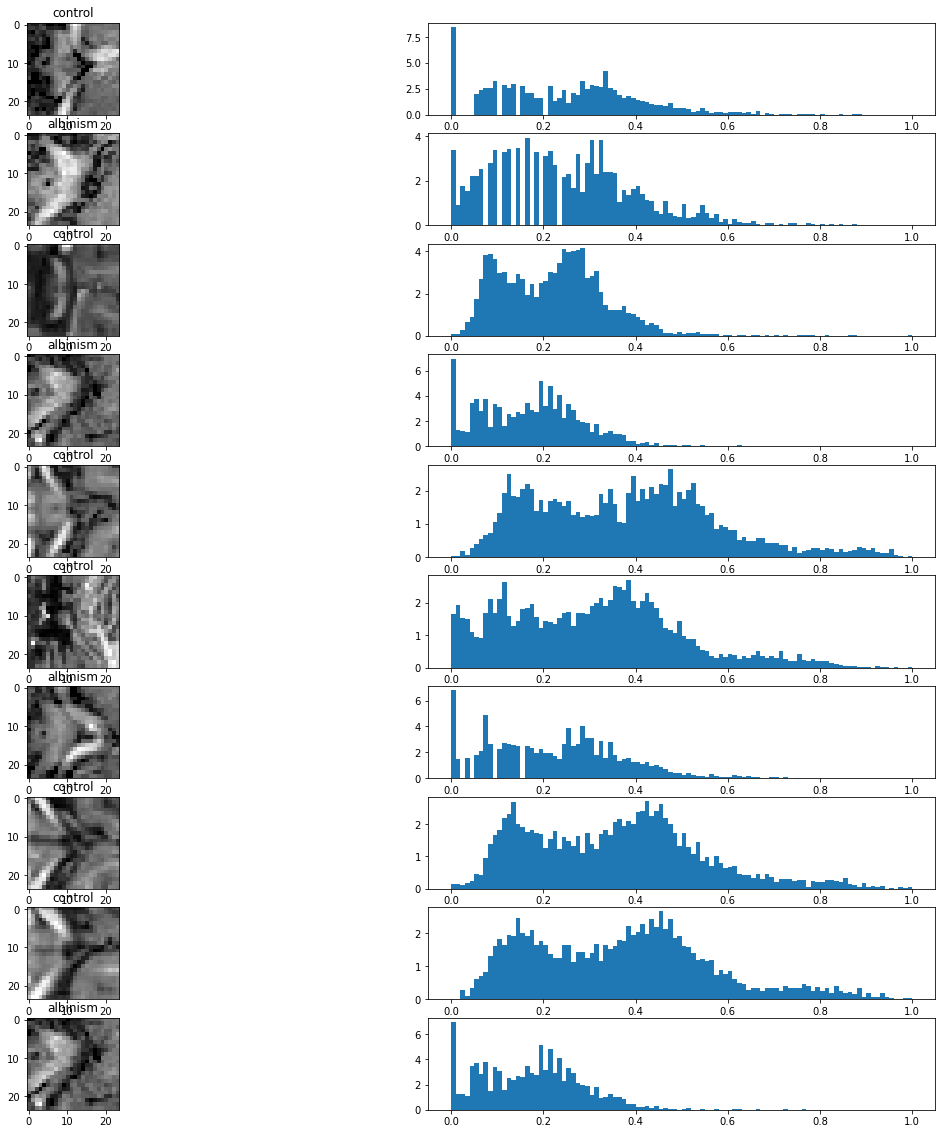

dev_train


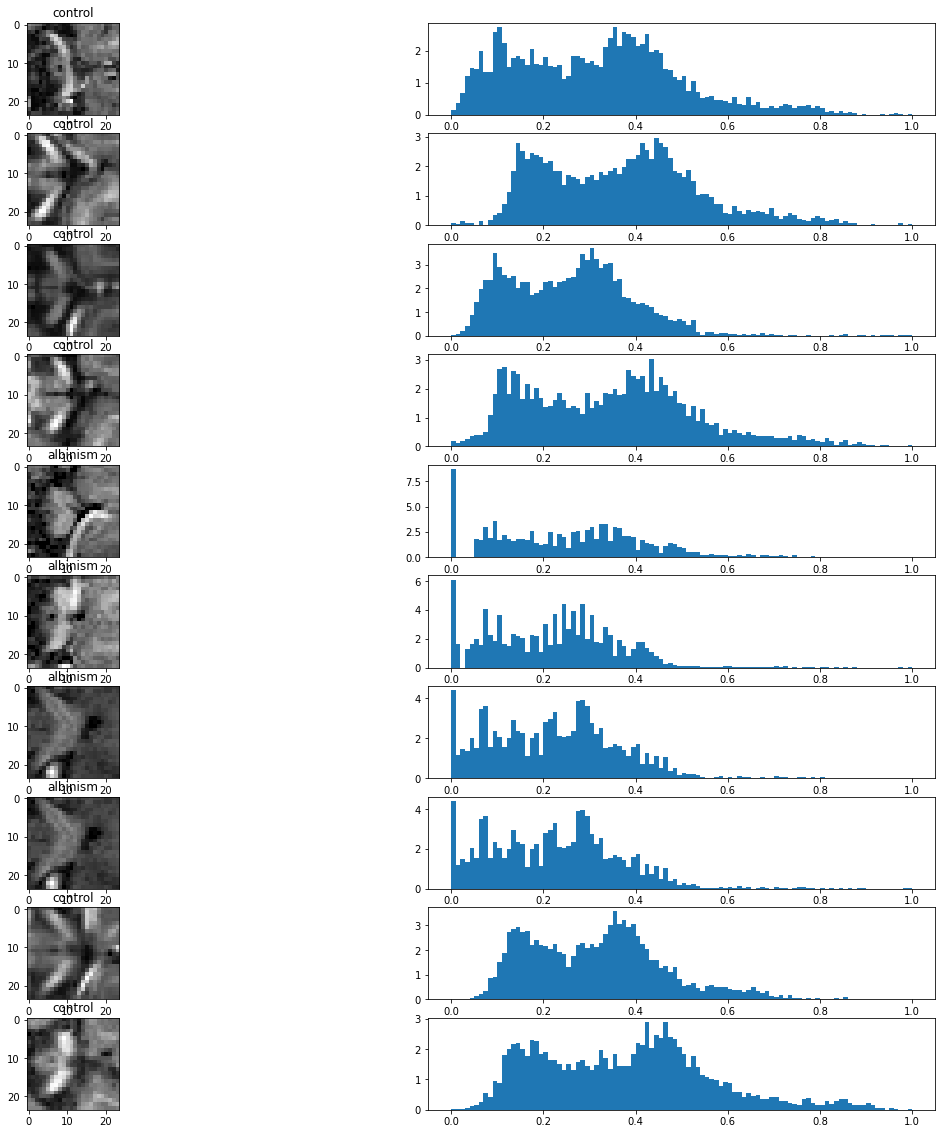

dev_test


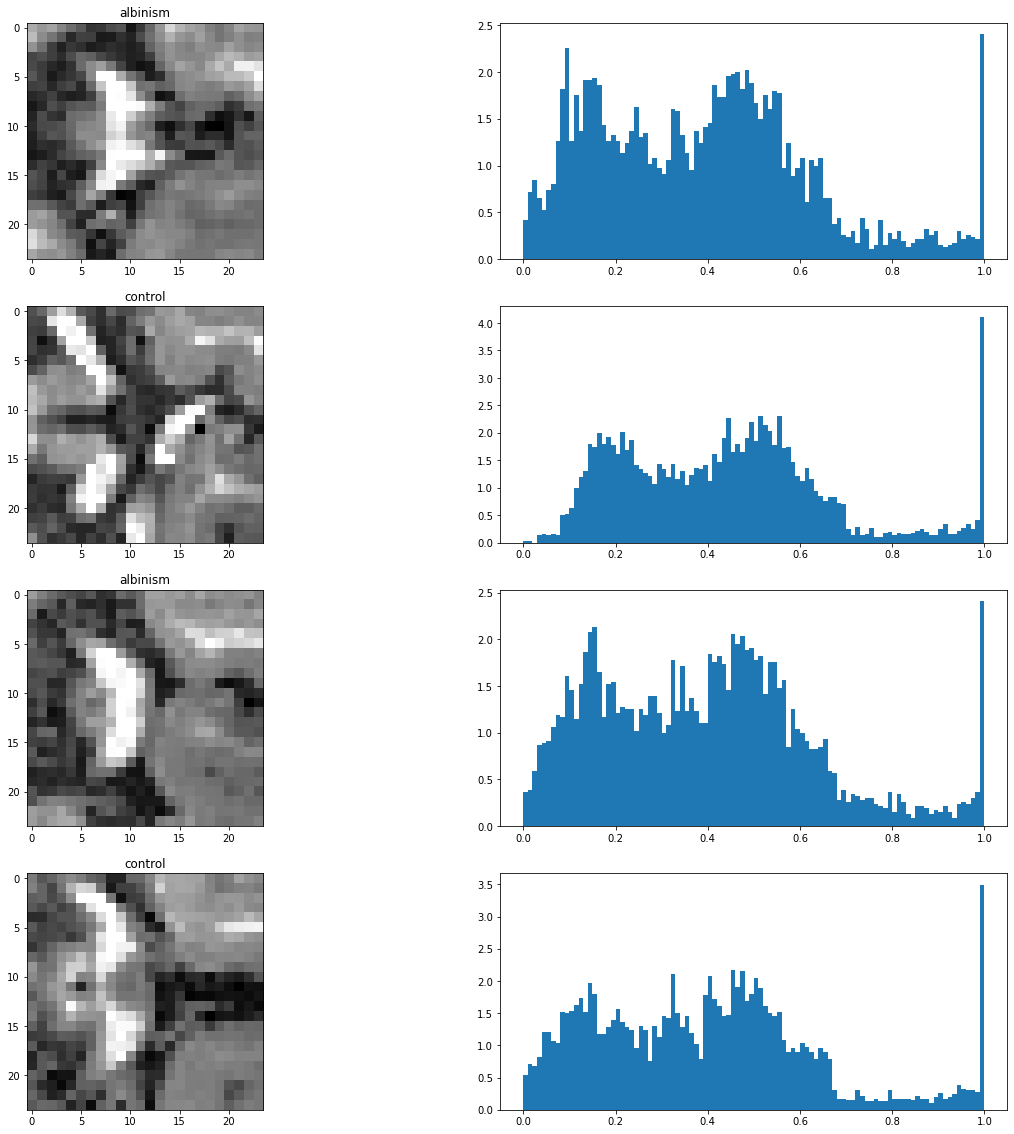

In [11]:
# Visualize results
classes=['control','albinism','other']

for group in ['train', 'dev_train', 'dev_test']:
    
    print(group)
    
    batch = next(enumerate(dataloaders_chiasm[group]))
    
    data = batch[1]['chiasm']['data']
    labels = batch[1]['label']
    
    inputs = data.cpu().numpy()

        
    fig = plt.figure(figsize=(20,20))
    
    for i in range(inputs.shape[0]):
        
        plt.subplot(inputs.shape[0],2,2*i+1)
        plt.imshow(inputs[i,0,:,:,5],cmap='gray');
        plt.title(classes[labels[i]])    
        plt.subplot(inputs.shape[0],2,2*i+2)
        plt.hist(inputs[i,0].reshape(-1),density=True, bins=100);
        plt.axis('on')
    
    plt.show()

# Models

In [12]:
# Cropped U-Net copied from Overfitting Model

class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, init_features=10, scaling=2):
        super(UNet, self).__init__()
                
        # Encoding layers
        self.encoder1 = self.unet_block(in_channels, init_features, "enc1")
        self.pool1 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder2 = self.unet_block(init_features, init_features*scaling, name='enc2')
        self.pool2 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)

        # Bottleneck layer
        self.bottleneck = self.unet_block(init_features*scaling, init_features*scaling**2, name='bottleneck')
        
        # Decoding layers (where merge with prevois encoding layers occurs)        
        self.upconv2 = nn.ConvTranspose3d(init_features*scaling**2, init_features*scaling, kernel_size=2, stride=2)
        self.decoder2 = self.unet_block(init_features*scaling, init_features*scaling, name='dec2')
                
        self.upconv1 = nn.ConvTranspose3d(init_features*scaling, init_features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(init_features, init_features, name='dec1')
        
        # Final convolution - output equals number of output channels
        self.conv = nn.Conv3d(init_features, out_channels, kernel_size=1) 
        
    def forward(self,x):
        
        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))

        # Upconvolving, concatenating data from respective encoding phase and executing UNet block
        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return torch.sigmoid(out_conv)
    
    def unet_block(self, in_channels, features, name):
        
        return nn.Sequential(OrderedDict([(name+'conv1',nn.Conv3d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm1', nn.BatchNorm3d(num_features=features)),
                             (name+'relu1', nn.ReLU(inplace=True)),
                             (name+'conv2', nn.Conv3d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm2', nn.BatchNorm3d(num_features=features)),
                             (name+'relu2', nn.ReLU(inplace=True))])
                            )

    def output_latent_representations(self,x):
        
        print(x.shape)

        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        print(bottleneck.shape)
        
        return bottleneck

In [13]:
class Classify_chiasm(nn.Module):
    
    def __init__(self, init_features, scaling, num_fc_layers, num_hidden_nodes, weights_path='../../1_Data/2_Trained_AE/'):
        super(Classify_chiasm, self).__init__()
        
        self.init_features = init_features
        self.scaling = scaling
        self.num_fc_layers = num_fc_layers
        self.num_hidden_nodes = num_hidden_nodes
        
        # Initialize the network_extracting_features and load its weights
        network_extracting_features = UNet(1,1,init_features,scaling)
        network_extracting_features.load_state_dict(torch.load(weights_path+'/'+str(init_features)+'_'+str(scaling)+'/optimal_weights'))
        
        child = network_extracting_features.children()
        
        # Copying the desired components (analysis stream) from network_extracting_features
        self.feature_extraction = nn.Sequential(*list(child)[:5])
        
        # Classification layers
        if self.num_fc_layers==0:
            self.classifier = nn.Linear(self.init_features*(self.scaling**2)*6*6*2,3)
        elif self.num_fc_layers==1:
            self.classifier = nn.Sequential(nn.Linear(self.init_features*(self.scaling**2)*6*6*2,self.num_hidden_nodes),nn.ReLU(),nn.Linear(self.num_hidden_nodes,3))
        
        # Placeholder for gradients
        self.gradients = None
    
    # Freeze all the layers apart from the classifying one
    def freeze_feature_extraction(self):
        
        counter = 0
        for layer in classifying_network.children():
            counter += 1
            if counter < 2:
                #print(layer)
                for param in layer.parameters():
                    param.requires_grad = False
            
    # Hook for the activations' gradients
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self,x):
        
        # To ensure that gradients will be tracked
        #x.requires_grad = True
        
        # Feature extraction
        x = self.feature_extraction(x)
        
        # Register the hook
        if self.train and x.requires_grad:
            h = x.register_hook(self.activations_hook)

        # Flatten the image
        #x = torch.flatten(x, start_dim=1)
        x = x.view((x.shape[0], -1))        

        # Classifying FC layer and activation function
        x = self.classifier(x)
        
        return torch.softmax(x, dim=1)

    # Output latent representations (or activations) of the last CNN layer
    def output_latent_representations(self,x):        
        return self.feature_extraction(x)     
    
    # Output gradient
    def output_activation_gradient(self):
        return self.gradients
    
    def gradcam_backup(self, x):
        
        # Calculate prediction
        pred = self.forward(x)
        
        # Get the gradient from the prediction
        pred.backward()
         
        # Extract the gradients from final layer extracting features
        gradients = self.output_activation_gradient()
        print(gradients.shape)
        
        # Pool the gradients
        pooled_gradients = torch.mean(gradients, dim=[0,2,3,4])
        
        # Extract activations
        activations = self.output_latent_representations(x).detach()
        
        # Weight activations by the gradients
        activations[:, i, :, :, :] *= pooled_gradients[i]
        
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        heatmap = np.maximum(heatmap, 0)
        
        heatmap /= torch.max(heatmap)
        
        return heatmap    
        
    def gradcam(self, x, class_id):

        # Calculate prediction
        pred = self.forward(x)

        # Get the gradient from the prediction
        pred[:,class_id].backward()

        # Extract the gradients from final layer extracting features
        gradients = self.output_activation_gradient()

        # Pool the gradients
        pooled_gradients = torch.mean(gradients, dim=[0,2,3,4])
        
        # Extract activations
        activations = self.output_latent_representations(x).detach()

        # Weight activations by the gradients
        for i in range(self.init_features * self.scaling**2):
            activations[:, i, :, :, :] *= pooled_gradients[i]

        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        # Limit heatmap to regions that positively contribute to given class
        heatmap = np.maximum(heatmap, 0)
        
        # Normalize it to 0
        heatmap /= torch.max(heatmap)
        
        return heatmap    

# Performance evaluation

In [14]:
def evaluate_accuracy(folder_with_networks, dataloader, dataset, group_to_be_evaluated):
    
    criterion = nn.NLLLoss(reduction='sum')
    
    names=[]
    loss=[]
    accuracy=[]
    f1=[]
    precision=[]
    recall=[]
    
    networks = [os.path.basename(x[0]) for x in os.walk(folder_with_networks)]
    networks=networks[1:]
     
    for network in networks:

        # Create network and load the weights
        params=network.split('_')

        model = Classify_chiasm(int(params[0]),int(params[1]),int(params[2]),int(params[3]))
        model.load_state_dict(torch.load(folder_with_networks+network+'/optimal_weights'))

        # Evaluate the network on desired dataset
        tmp_loss=0.0
        tmp_targets=[]
        tmp_pred=[]
        
        for batch in dataloader[group_to_be_evaluated]:
            
            data=batch['chiasm']['data']
                        
            with torch.no_grad():
                
                output = model(data)
                
                tmp_loss +=(criterion(output,batch['label']).item())

                tmp_targets+=batch['label'][:].numpy().tolist()
                tmp_pred+=output.argmax(dim=1).cpu().numpy().tolist()

        names.append(network)
        loss.append(tmp_loss/len(dataset[group_to_be_evaluated]))
        accuracy.append(accuracy_score(tmp_targets,tmp_pred))
        f1.append(f1_score(tmp_targets,tmp_pred, average='weighted'))
        precision.append(precision_score(tmp_targets,tmp_pred, average='weighted'))
        recall.append(recall_score(tmp_targets,tmp_pred, average='weighted'))
        
    # Return the list with results
    return names,loss,accuracy, f1, precision,recall

In [15]:
def plot_training(path_to_saved_output):
    
    with open(path_to_saved_output+'train_loss.pkl', 'rb') as f:
        train_loss=pickle.load(f)

    with open(path_to_saved_output+'dev_train_loss.pkl', 'rb') as f:
        dev_train_loss=pickle.load(f)

    with open(path_to_saved_output+'dev_test_loss.pkl', 'rb') as f:
        dev_test_loss=pickle.load(f)

    with open(path_to_saved_output+'train_acc.pkl', 'rb') as f:
        train_acc=pickle.load(f)

    with open(path_to_saved_output+'dev_train_acc.pkl', 'rb') as f:
        dev_train_acc=pickle.load(f)

    with open(path_to_saved_output+'dev_test_acc.pkl', 'rb') as f:
        dev_test_acc=pickle.load(f)
                
    fig = plt.figure(figsize=(20,5))
    plt.suptitle(os.path.basename(path_to_saved_output))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, label='train')
    plt.plot(dev_train_loss, label='train_dev')
    plt.plot(dev_test_loss, label='test_dev')
    plt.legend();
    plt.title('Loss');
    
    plt.subplot(1,2,2)
    plt.plot(train_acc, label='train')
    plt.plot(dev_train_acc, label='train_dev')
    plt.plot(dev_test_acc, label='test_dev')
    plt.legend();
    plt.title('Accuracy');

In [16]:
def plot_evaluation(names_list, loss_list, acc_list, f1_list, precision_list, recall_list, name):
    
    # order lists
    loss_list, names_list, acc_list, f1_list, precision_list, recall_list = (list(t) for t in zip(*sorted(zip(loss_list, names_list, acc_list, f1_list, precision_list, recall_list))))
    
    # plot with subplots
    fig = plt.figure(figsize=(16,12))
    plt.suptitle(name)
    
    # Cross-entropy loss
    ax1 = plt.subplot(511)
    plt.scatter(names_list, loss_list)
    plt.xticks(rotation=90);
    plt.axhline(y=-0.5, color='r', linestyle='--')
    plt.ylim([-1,0])
    ax1.axes.get_xaxis().set_ticks([])
    plt.title('Losses')
    
    # Accuracy
    ax2 = plt.subplot(512)
    plt.scatter(names_list, acc_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.5, color='r', linestyle='--')
    plt.ylim([-0.05,1.05])
    ax2.axes.get_xaxis().set_ticks([])
    plt.title('Accuracy')
    
    # Precision
    ax2 = plt.subplot(513)
    plt.scatter(names_list, precision_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.5, color='r', linestyle='--')
    plt.ylim([-0.05,1.05])
    ax2.axes.get_xaxis().set_ticks([])
    plt.title('Precision')
    
    # Recall
    ax2 = plt.subplot(514)
    plt.scatter(names_list, recall_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.5, color='r', linestyle='--')
    plt.ylim([-0.05,1.05])
    ax2.axes.get_xaxis().set_ticks([])
    plt.title('Recall')
    
    # F1 score
    ax3 = plt.subplot(515)
    plt.scatter(names_list, f1_list)
    plt.xticks(rotation=90);
    plt.axhline(y=0.5, color='r', linestyle='--')
    plt.ylim([-0.05,1.05])
    plt.title('F1-score')

## Accuracy

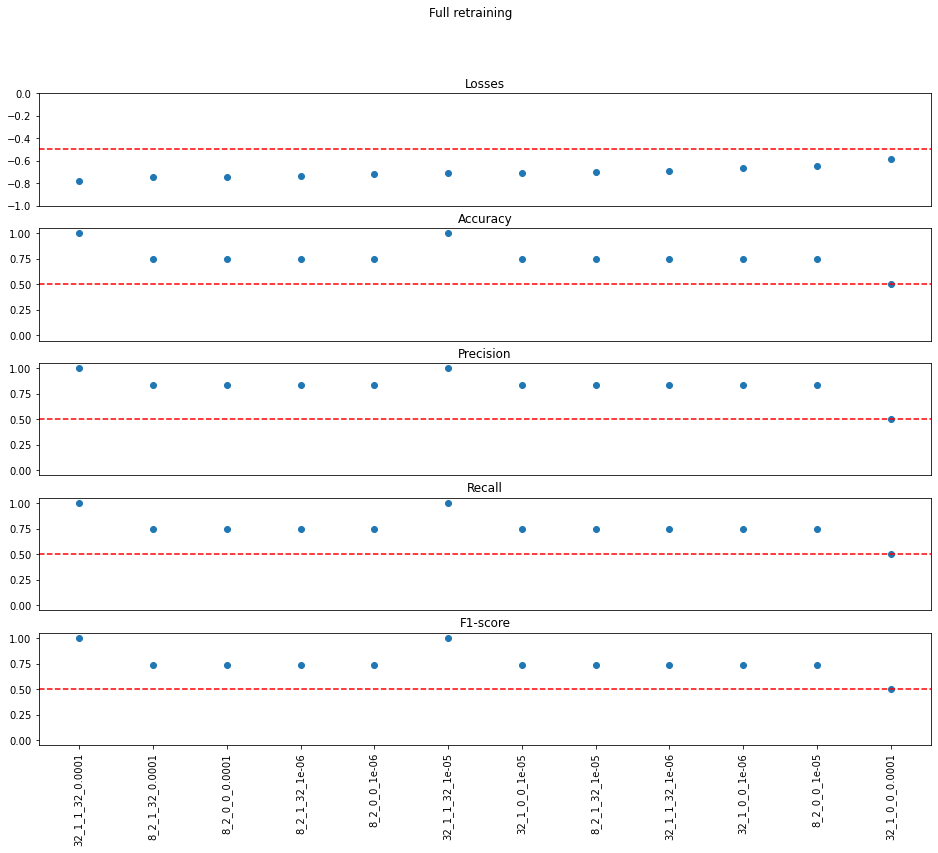

In [17]:
# Full retraining
plot_names, plot_loss, plot_accuracy, f1, precision, recall = evaluate_accuracy('../../1_Data/3_Trained_classifier_full_retraining//', dataloaders_chiasm, concatenated_datasets, 'dev_test')
plot_evaluation(plot_names, plot_loss, plot_accuracy, f1, precision, recall, 'Full retraining')

/home/rjp/Software/anaconda3/envs/optic_chiasm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rjp/Software/anaconda3/envs/optic_chiasm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rjp/Software/anaconda3/envs/optic_chiasm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

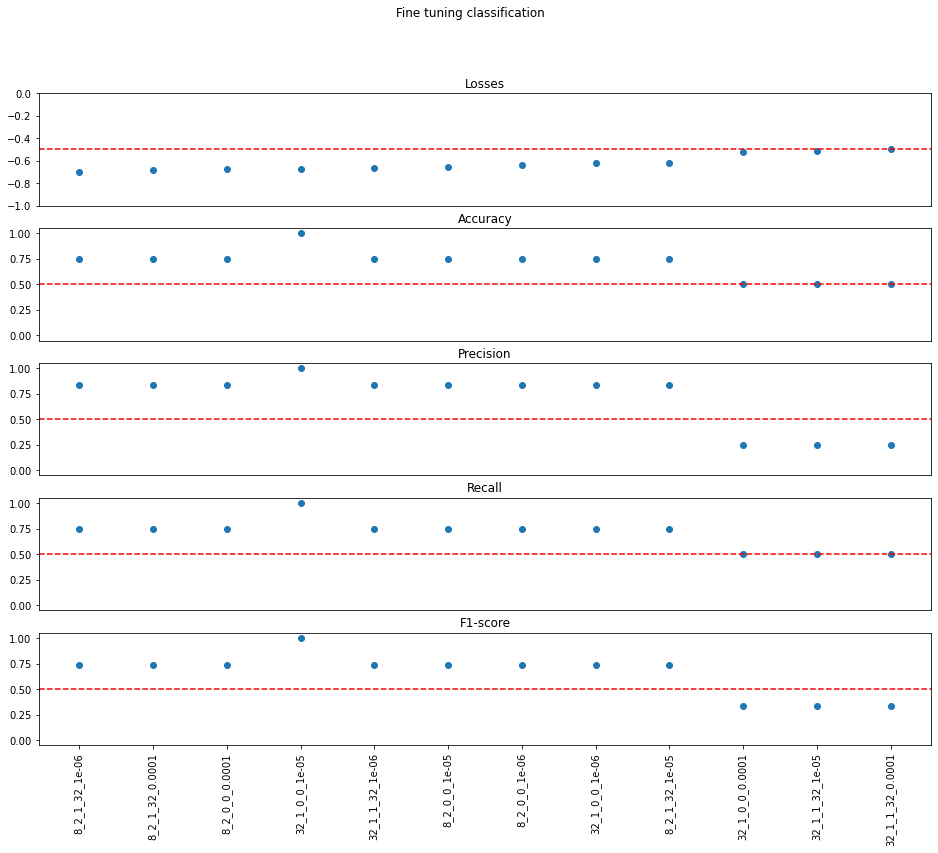

In [18]:
# Fine tuning classification
plot_names, plot_loss, plot_accuracy, f1, precision, recall = evaluate_accuracy('../../1_Data/3_Trained_classifier_finetuning_classification///', dataloaders_chiasm, concatenated_datasets, 'dev_test')
plot_evaluation(plot_names, plot_loss, plot_accuracy, f1, precision, recall, 'Fine tuning classification')

/home/rjp/Software/anaconda3/envs/optic_chiasm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rjp/Software/anaconda3/envs/optic_chiasm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rjp/Software/anaconda3/envs/optic_chiasm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

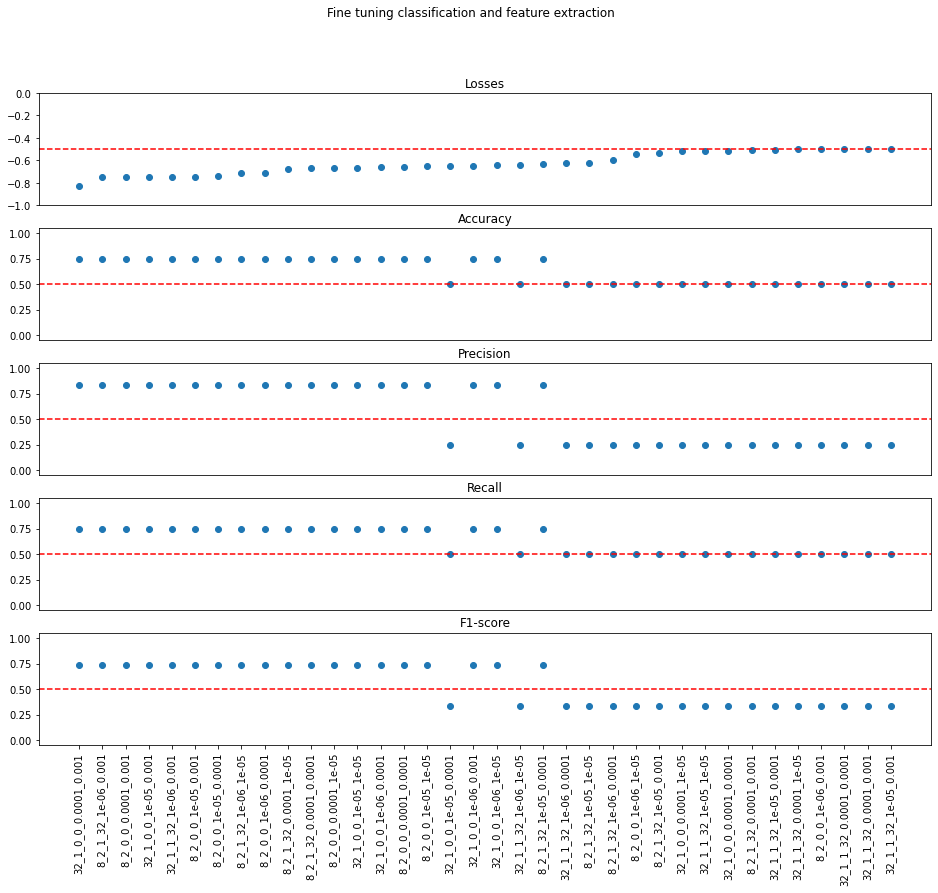

In [19]:
# Fine tuning classification and feature extraction
plot_names, plot_loss, plot_accuracy, f1, precision, recall = evaluate_accuracy('../../1_Data/3_Trained_classifier_finetuning_classification_feature_extraction//', dataloaders_chiasm, concatenated_datasets, 'dev_test')
plot_evaluation(plot_names, plot_loss, plot_accuracy, f1, precision, recall, 'Fine tuning classification and feature extraction')

## Training plots

32_1_1_32_0.0001


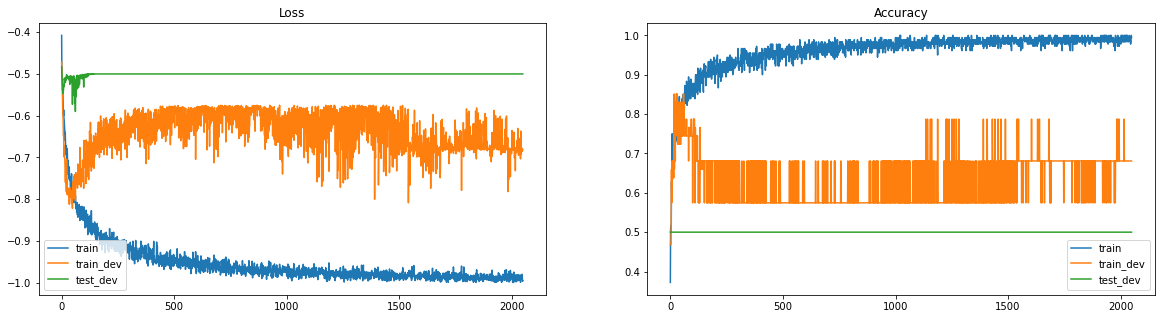

32_1_1_32_1e-05


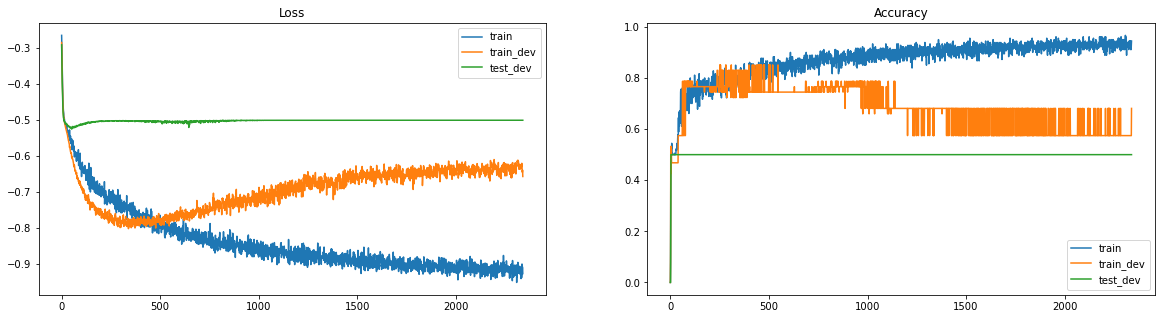

8_2_1_32_0.0001


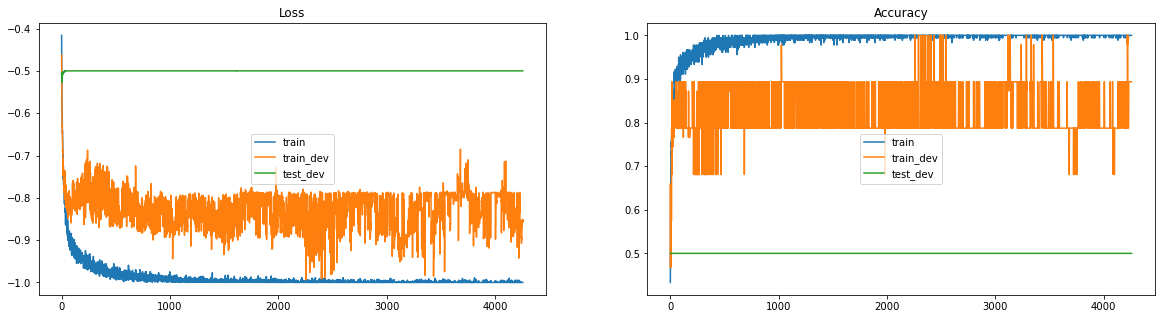

In [20]:
# Full retraining
networks=['32_1_1_32_0.0001','32_1_1_32_1e-05','8_2_1_32_0.0001']

for i in networks:
    print(i)
    plot_training('../../1_Data/3_Trained_classifier_full_retraining/'+i+'/')
    plt.show()

32_1_0_0_1e-05


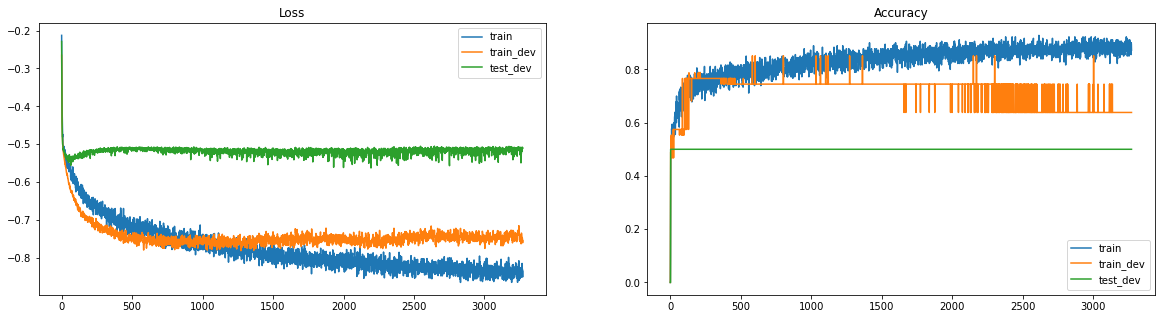

8_2_1_32_1e-06


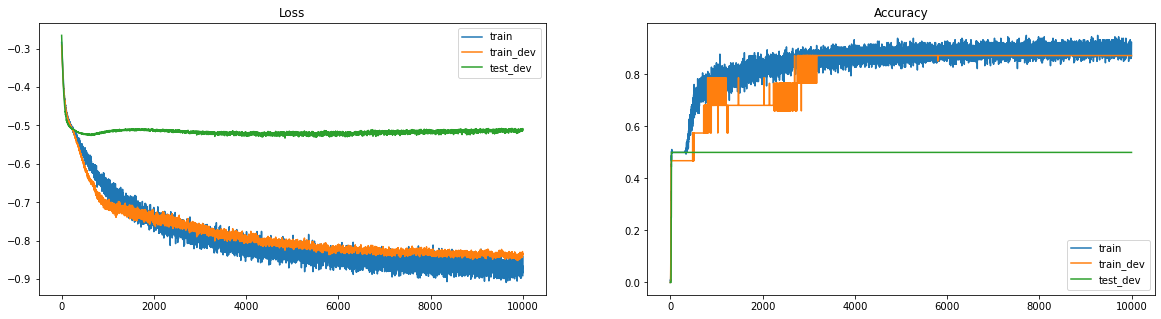

8_2_1_32_0.0001


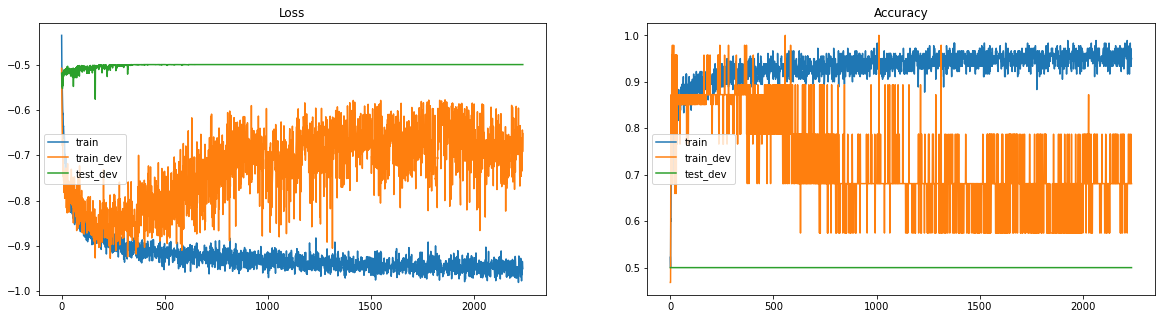

In [21]:
# Fine tuning classification
networks=['32_1_0_0_1e-05','8_2_1_32_1e-06','8_2_1_32_0.0001']

for i in networks:
    print(i)
    plot_training('../../1_Data/3_Trained_classifier_finetuning_classification/'+i+'/')
    plt.show()

32_1_0_0_0.0001_0.001


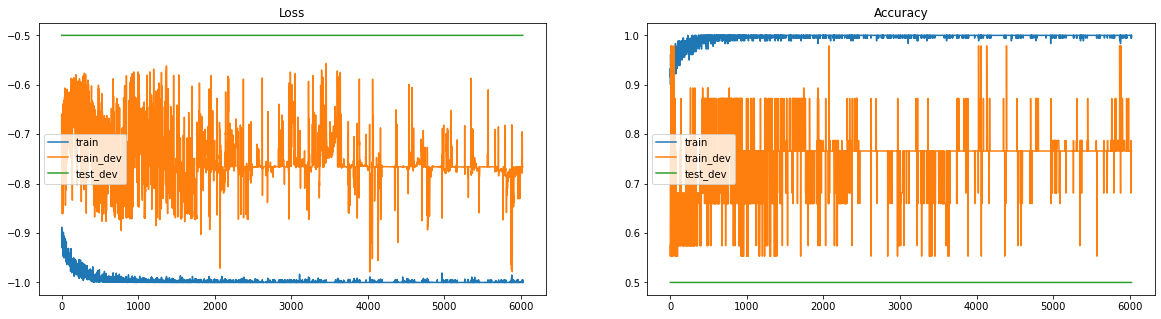

8_2_1_32_1e-06_0.001


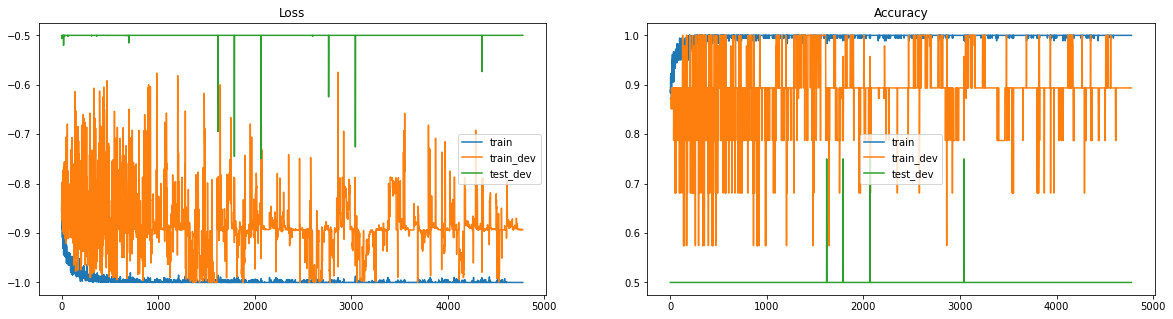

8_2_0_0_0.0001_0.001


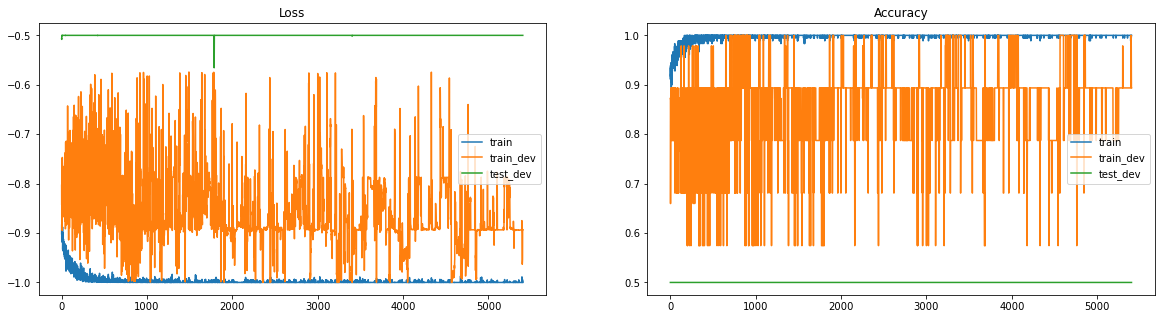

In [22]:
# Fine tuning classification+feature extraction
networks=['32_1_0_0_0.0001_0.001','8_2_1_32_1e-06_0.001','8_2_0_0_0.0001_0.001']

for i in networks:
    print(i)
    plot_training('../../1_Data/3_Trained_classifier_finetuning_classification_feature_extraction/'+i+'/')
    plt.show()

In [23]:
#networks = [os.path.basename(x[0]) for x in os.walk('../../1_Data/3_Trained_classifier_finetuning_classification_feature_extraction//')]
#networks=networks[1:]

#for i in networks:
#    print(i)
#    plot_training('../../1_Data/3_Trained_classifier_finetuning_classification_feature_extraction//'+i+'/')
#    plt.show()

## GradCAM

In [24]:
def translate_group(index):
    
    if (index==0):
        return 'control'
    elif (index ==1):
        return 'albinism'
    elif (index==2):
        return 'other'

In [25]:
def plot_gradcam(folder_with_networks, dataloader, group_to_be_evaluated, slice_to_be_shown, architectures=None):
    
    if architectures==None:
        networks = [os.path.basename(x[0]) for x in os.walk(folder_with_networks)]
        networks=networks[1:]
    else:
        networks=architectures
    
    # Fetch data used for evaluation
    batch=next(enumerate(dataloader[group_to_be_evaluated]))[1]
    
    for network in networks:#[0:1]:
        
        print(network)
        
        # Initialize the model
        params=network.split('_')

        model = Classify_chiasm(int(params[0]),int(params[1]),int(params[2]),int(params[3]))
        model.load_state_dict(torch.load(folder_with_networks+network+'/optimal_weights'))
        
        prediction = model(batch['chiasm']['data'])
        
        #print(prediction)
        
        accuracy = accuracy_score(batch['label'],prediction.cpu().argmax(dim=1))
        print('Accuracy = ',accuracy)

        plt.figure(figsize=(10,10))
        
        for i in range(len(batch['label'])):
            
            
            # original image
            plt.subplot(len(batch['label']),3,3*i+1)
            plt.imshow(batch['chiasm']['data'][i:(i+1)][0,0,:,:,i], cmap='gray', alpha=1)    
            plt.ylabel(translate_group(batch['label'][i]))
            plt.tick_params(axis='both', labelsize=0, length = 0)
            
            # explanation for control
            explanation=model.gradcam(batch['chiasm']['data'][i:(i+1)],0)
            explanation = zoom(explanation,(4,4,4))
            
            plt.subplot(len(batch['label']),3,3*i+2)
            plt.imshow(explanation[:,:,i], cmap='jet', alpha=1)    
            plt.tick_params(axis='both', labelsize=0, length = 0)
            plt.xlabel("{:.2f}".format(prediction[i,0].item()))
            if(i==0):
                plt.title('control')
            
            # explanation for albinism
            explanation=model.gradcam(batch['chiasm']['data'][i:(i+1)],1)
            explanation = zoom(explanation,(4,4,4))
            
            plt.subplot(len(batch['label']),3,3*i+3)
            plt.imshow(explanation[:,:,i], cmap='jet', alpha=1)    
            plt.tick_params(axis='both', labelsize=0, length = 0)
            plt.xlabel("{:.2f}".format(prediction[i,1].item()))
            if(i==0):
                plt.title('albinism')            
                
        plt.show()

In [47]:
def plot_occlusion(folder_with_networks, dataloader, group_to_be_evaluated, slice_to_be_shown, architectures=None):
    
    if architectures==None:
        networks = [os.path.basename(x[0]) for x in os.walk(folder_with_networks)]
        networks=networks[1:]
    else:
        networks=architectures
    
    # Fetch data used for evaluation
    batch=next(enumerate(dataloader[group_to_be_evaluated]))[1]
    
    for network in networks:#[0:1]:
        
        print(network)
        
        # Initialize the model
        params=network.split('_')

        model = Classify_chiasm(int(params[0]),int(params[1]),int(params[2]),int(params[3]))
        model.load_state_dict(torch.load(folder_with_networks+network+'/optimal_weights'))
        
        # Calculate the accuracy
        prediction = model(batch['chiasm']['data'])
        accuracy = accuracy_score(batch['label'],prediction.cpu().argmax(dim=1))
        print(accuracy)
        
        # Plot the explanation provided by occlusion model
        occlusion = Occlusion(model)
        
        plt.figure(figsize=(10,10))
        
        for i in range(len(batch['label'])):
            
            input=batch['chiasm']['data'][i].unsqueeze(0)
            
            attributions_occ_zero = occlusion.attribute(input,
                                       target=0,
                                       sliding_window_shapes=(1,3,3,1),
                                       baselines=0)


            attributions_occ_one = occlusion.attribute(input,
                                       target=1,
                                       sliding_window_shapes=(1,3,3,1),
                                       baselines=0)
            
            # original image
            plt.subplot(len(batch['label']),3,3*i+1)
            plt.imshow(batch['chiasm']['data'][i:(i+1)][0,0,:,:,i], cmap='gray', alpha=1)    
            plt.ylabel(translate_group(batch['label'][i]))
            plt.tick_params(axis='both', labelsize=0, length = 0)
            
            # explanation for control           
            plt.subplot(len(batch['label']),3,3*i+2)
            plt.imshow(attributions_occ_zero[0,0,:,:,i], cmap='jet', alpha=1)    
            plt.tick_params(axis='both', labelsize=0, length = 0)
            plt.xlabel("{:.2f}".format(prediction[i,0].item()))
            if(i==0):
                plt.title('control')
            
            # explanation for albinism            
            plt.subplot(len(batch['label']),3,3*i+3)
            plt.imshow(attributions_occ_one[0,0,:,:,i], cmap='jet', alpha=1)    
            plt.tick_params(axis='both', labelsize=0, length = 0)
            plt.xlabel("{:.2f}".format(prediction[i,1].item()))
            if(i==0):
                plt.title('albinism')            
                
        plt.show()

32_1_1_32_0.0001
1.0


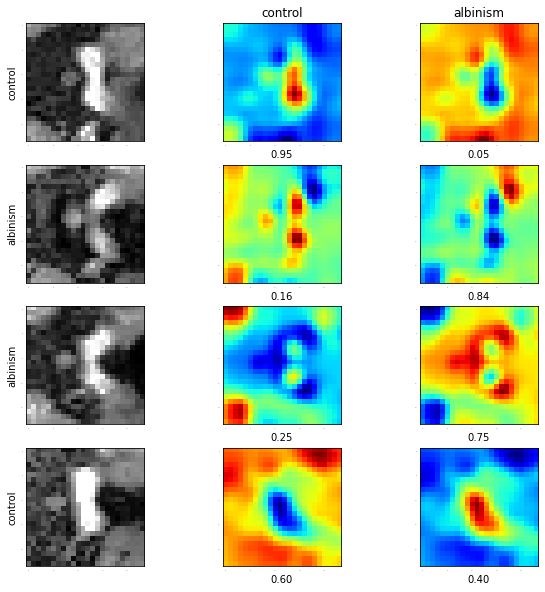

In [53]:
# Full retraining
#plot_gradcam('../../1_Data/3_Trained_classifier_full_retraining/',dataloaders_chiasm,'dev_test',3,['32_1_0_0_1e-06','32_1_1_32_0.0001','32_1_0_0_1e-05'])
# chosen 32_1_0_0_1e-06
plot_occlusion('../../1_Data/3_Trained_classifier_full_retraining/',dataloaders_chiasm,'dev_test',3,['32_1_1_32_0.0001'])

32_1_0_0_1e-06
0.75


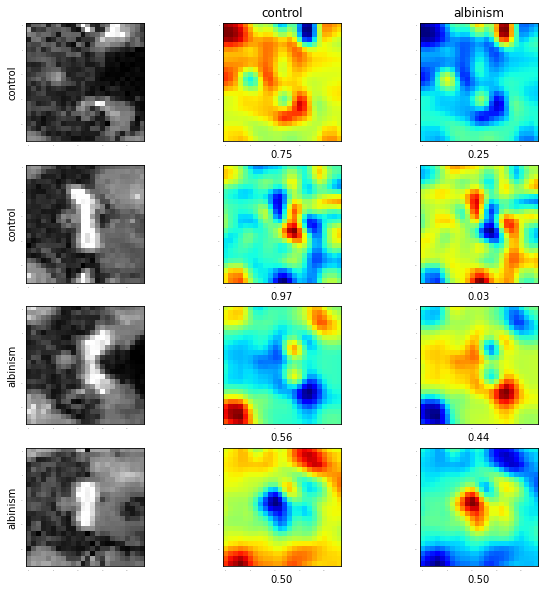

In [48]:
# Full retraining
#plot_gradcam('../../1_Data/3_Trained_classifier_full_retraining/',dataloaders_chiasm,'dev_test',3,['32_1_0_0_1e-06','32_1_1_32_0.0001','32_1_0_0_1e-05'])
# chosen 32_1_0_0_1e-06
plot_occlusion('../../1_Data/3_Trained_classifier_full_retraining/',dataloaders_chiasm,'dev_test',3,['32_1_0_0_1e-06'])

8_2_0_0_1e-06
0.75


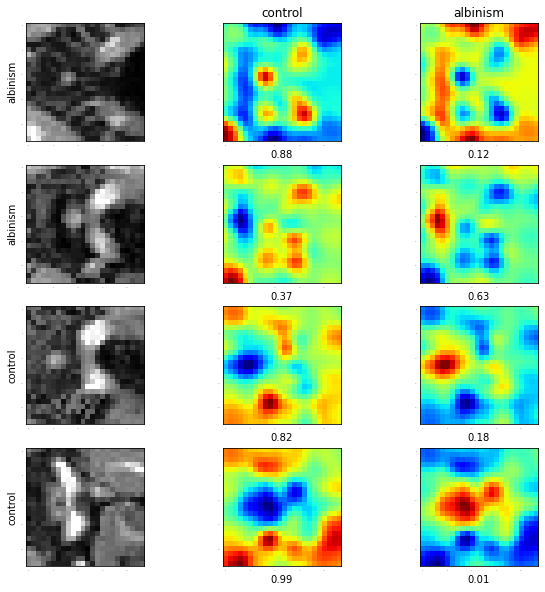

In [49]:
# Fine tuning classification
#plot_gradcam('../../1_Data/3_Trained_classifier_finetuning_classification/',dataloaders_chiasm,'dev_test',6,['8_2_0_0_1e-06','32_1_1_32_1e-06'])
# chosen 8_2_0_0_1e-06 
plot_occlusion('../../1_Data/3_Trained_classifier_finetuning_classification/',dataloaders_chiasm,'dev_test',6,['8_2_0_0_1e-06'])


32_1_0_0_1e-05_1e-05
0.75


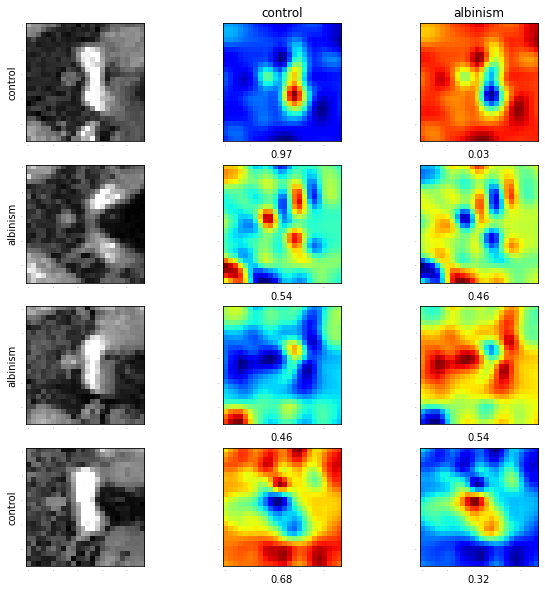

In [50]:
# Fine tuning classification + feature extraction
#plot_gradcam('../../1_Data/3_Trained_classifier_finetuning_classification_feature_extraction/',dataloaders_chiasm,'dev_test',6,['32_1_0_0_1e-06_0.0001','32_1_0_0_1e-05_1e-05'])
# chosen 32_1_0_0_1e-05_1e-05
plot_occlusion('../../1_Data/3_Trained_classifier_finetuning_classification_feature_extraction/',dataloaders_chiasm,'dev_test',6,['32_1_0_0_1e-05_1e-05'])


In [51]:
# From previous trainings
#plot_gradcam('../../1_Data/X_Training_NLLLoss/3_Trained_classifier_fc_layer_only/',dataloaders_chiasm,'dev_test',6)
# chosen 32_1_0_0_1e-05
#plot_occlusion('../../1_Data/X_Training_NLLLoss/3_Trained_classifier_fc_layer_only/',dataloaders_chiasm,'dev_test',6)

# Performance on averaged data

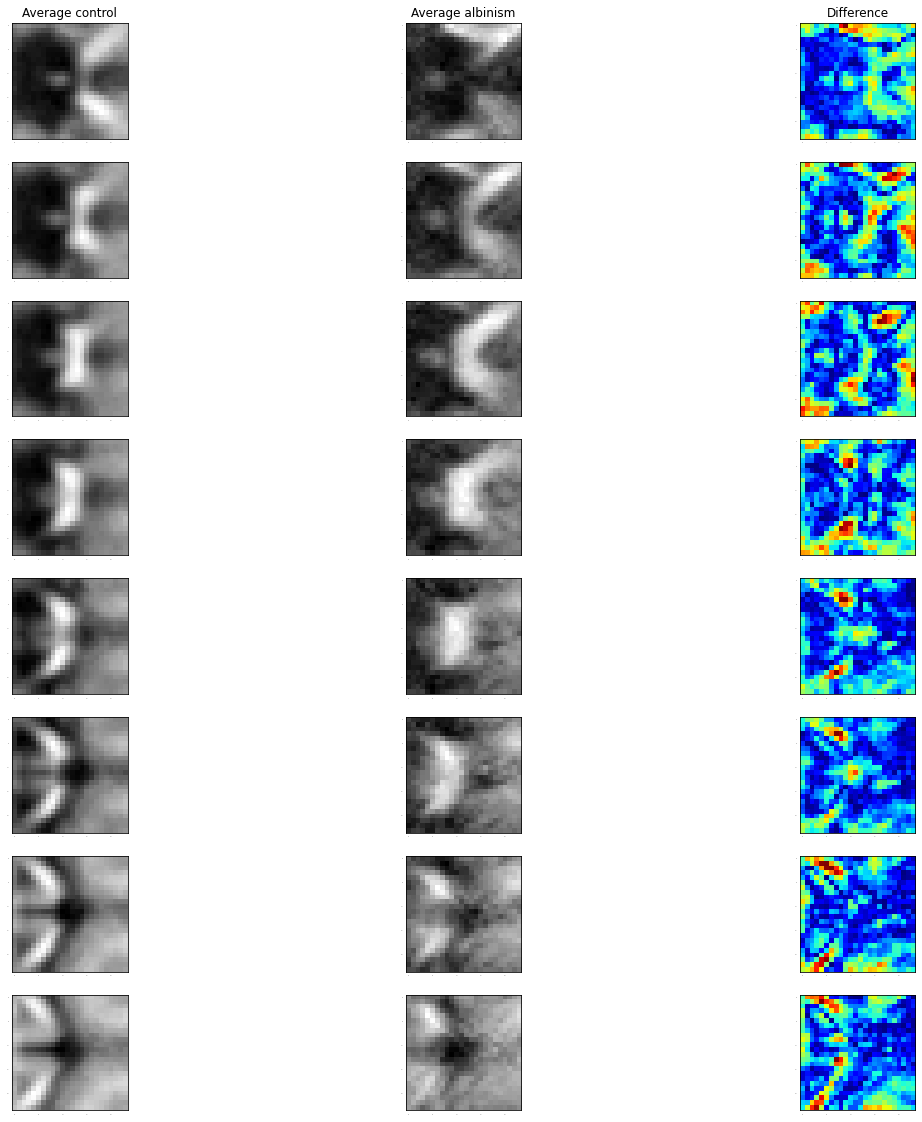

In [28]:
# Calculate average input

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))
average_other = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:    
    average_control+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==1], axis=(0,1))
    
average_control /= np.max(average_control)
average_albinism /= np.max(average_albinism)

plt.figure(figsize=(20,20))

for i in range(8):
        
    # Control
    plt.subplot(8,3,3*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average control')
    
    # Albinism
    plt.subplot(8,3,3*i+2)
    plt.imshow(average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average albinism')
        
    # Difference
    plt.subplot(8,3,3*i+3)
    plt.imshow(np.abs(average_control[:,:,i]-average_albinism[:,:,i]), cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference')


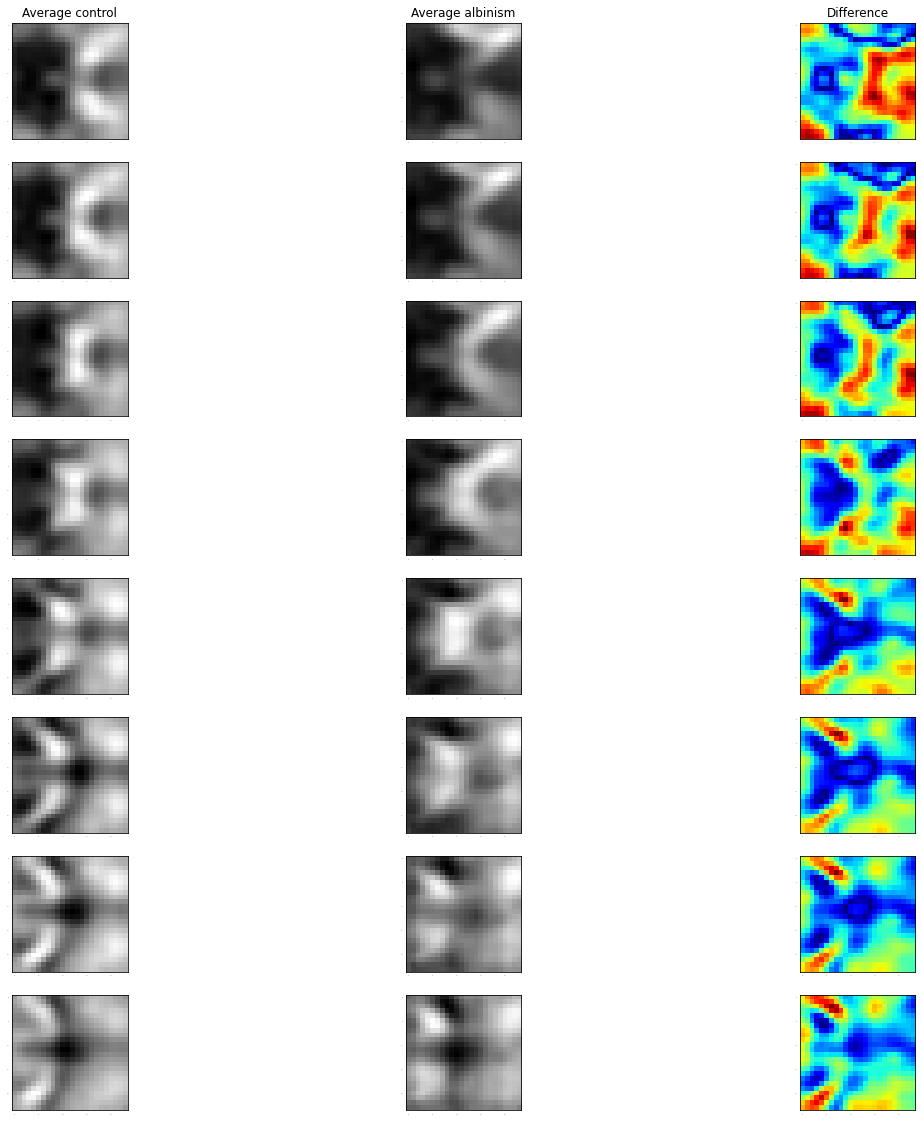

In [29]:
# Calculate average input after AE step

ae = UNet(1,1,32,1)
ae.load_state_dict(torch.load('../../1_Data/2_Trained_AE/32_1/optimal_weights'))

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))
average_other = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:  
                              
    output = ae(batch['chiasm']['data']).detach().numpy()                
                                                       
    average_control+=np.sum(output[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(output[batch['label'].numpy()==1], axis=(0,1))
    average_other+=np.sum(output[batch['label'].numpy()==2], axis=(0,1))
    
average_control /= np.max(average_control)
average_albinism /= np.max(average_albinism)

plt.figure(figsize=(20,20))

for i in range(8):
        
    # Control
    plt.subplot(8,3,3*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average control')
    
    # Albinism
    plt.subplot(8,3,3*i+2)
    plt.imshow(average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average albinism')
        
    # Difference
    plt.subplot(8,3,3*i+3)
    plt.imshow(np.abs(average_control[:,:,i]-average_albinism[:,:,i]), cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference')


Control


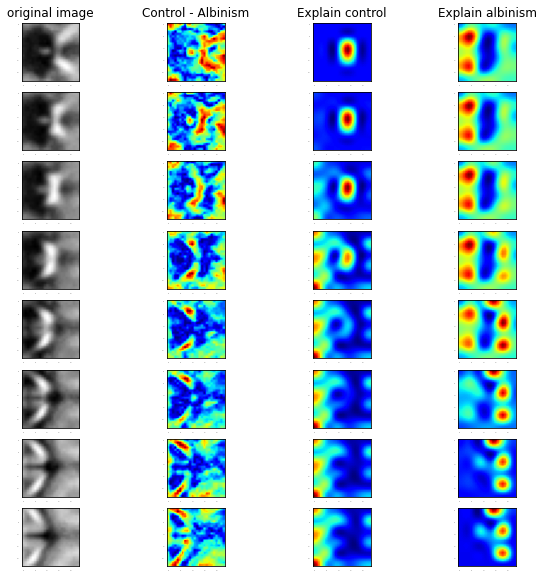

albinism


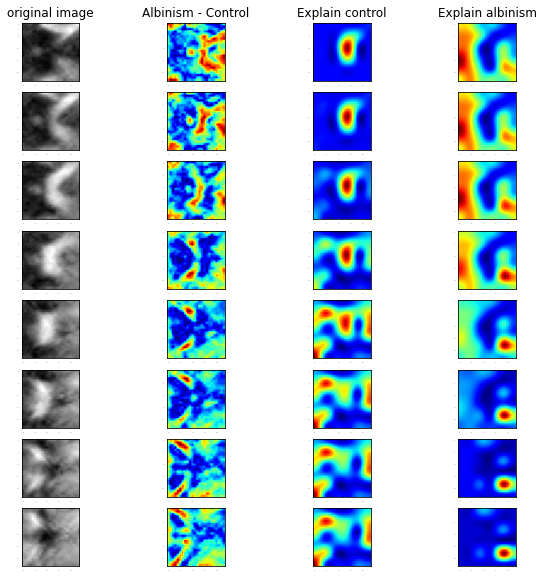

In [30]:
# Full retrain GradCAM

# Calculate average input

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:    
    average_control+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==1], axis=(0,1))
    
# Initialize model
model = Classify_chiasm(32,1,0,0)
model.load_state_dict(torch.load('../../1_Data/3_Trained_classifier_full_retraining/32_1_0_0_1e-06/optimal_weights'))


# Plots for control
print('Control')

explain_control = model.gradcam(torch.from_numpy(average_control).unsqueeze(0).unsqueeze(0).float(),0)
explain_control = zoom(explain_control,(4,4,4))

explain_albinism = model.gradcam(torch.from_numpy(average_control).unsqueeze(0).unsqueeze(0).float(),1)
explain_albinism = zoom(explain_albinism,(4,4,4))


plt.figure(figsize=(10,10))
for i in range(8):

    # Original image
    plt.subplot(8,4,4*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('original image');
        
    # Show difference
    plt.subplot(8,4,4*i+2)
    plt.imshow(np.abs(average_control[:,:,i]-average_albinism[:,:,i]), cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Control - Albinism');

    # Explain control
    plt.subplot(8,4,4*i+3)
    plt.imshow(explain_control[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain control');
        
    # Explain albinism
    plt.subplot(8,4,4*i+4)
    plt.imshow(explain_albinism[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain albinism');
      
plt.show()
        
# Plots for albinism
print('albinism')

explain_control = model.gradcam(torch.from_numpy(average_albinism).unsqueeze(0).unsqueeze(0).float(),0)
explain_control = zoom(explain_control,(4,4,4))

explain_albinism = model.gradcam(torch.from_numpy(average_albinism).unsqueeze(0).unsqueeze(0).float(),1)
explain_albinism = zoom(explain_albinism,(4,4,4))

plt.figure(figsize=(10,10))
for i in range(8):

    # Original image
    plt.subplot(8,4,4*i+1)
    plt.imshow(average_albinism[:,:,i], cmap='gray', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('original image');

    # Explain control
    plt.subplot(8,4,4*i+2)
    plt.imshow(np.abs(average_albinism[:,:,i]-average_control[:,:,i]), cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Albinism - Control');
    
    # Explain control
    plt.subplot(8,4,4*i+3)
    plt.imshow(explain_control[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain control');
        
    # Explain albinism
    plt.subplot(8,4,4*i+4)
    plt.imshow(explain_albinism[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain albinism');


plt.show()


Control


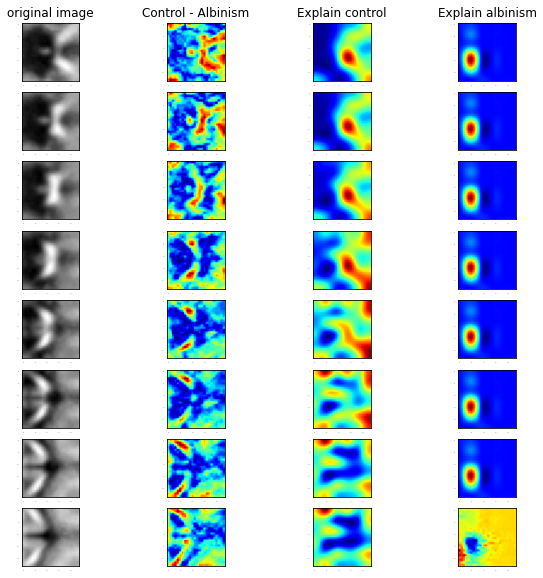

albinism


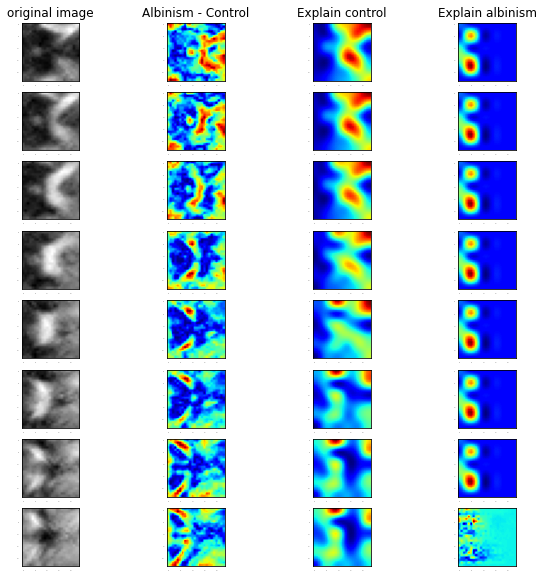

In [31]:
# Fine tune classification GradCAM

# Calculate average input

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:    
    average_control+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==1], axis=(0,1))
    
# Initialize model
model = Classify_chiasm(8,2,0,0)
model.load_state_dict(torch.load('../../1_Data/3_Trained_classifier_finetuning_classification/8_2_0_0_1e-06/optimal_weights'))


# Plots for control
print('Control')

explain_control = model.gradcam(torch.from_numpy(average_control).unsqueeze(0).unsqueeze(0).float(),0)
explain_control = zoom(explain_control,(4,4,4))

explain_albinism = model.gradcam(torch.from_numpy(average_control).unsqueeze(0).unsqueeze(0).float(),1)
explain_albinism = zoom(explain_albinism,(4,4,4))


plt.figure(figsize=(10,10))
for i in range(8):

    # Original image
    plt.subplot(8,4,4*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('original image');
        
    # Show difference
    plt.subplot(8,4,4*i+2)
    plt.imshow(np.abs(average_control[:,:,i]-average_albinism[:,:,i]), cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Control - Albinism');

    # Explain control
    plt.subplot(8,4,4*i+3)
    plt.imshow(explain_control[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain control');
        
    # Explain albinism
    plt.subplot(8,4,4*i+4)
    plt.imshow(explain_albinism[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain albinism');
      
plt.show()
        
# Plots for albinism
print('albinism')

explain_control = model.gradcam(torch.from_numpy(average_albinism).unsqueeze(0).unsqueeze(0).float(),0)
explain_control = zoom(explain_control,(4,4,4))

explain_albinism = model.gradcam(torch.from_numpy(average_albinism).unsqueeze(0).unsqueeze(0).float(),1)
explain_albinism = zoom(explain_albinism,(4,4,4))

plt.figure(figsize=(10,10))
for i in range(8):

    # Original image
    plt.subplot(8,4,4*i+1)
    plt.imshow(average_albinism[:,:,i], cmap='gray', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('original image');

    # Explain control
    plt.subplot(8,4,4*i+2)
    plt.imshow(np.abs(average_albinism[:,:,i]-average_control[:,:,i]), cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Albinism - Control');
    
    # Explain control
    plt.subplot(8,4,4*i+3)
    plt.imshow(explain_control[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain control');
        
    # Explain albinism
    plt.subplot(8,4,4*i+4)
    plt.imshow(explain_albinism[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain albinism');


plt.show()


Control


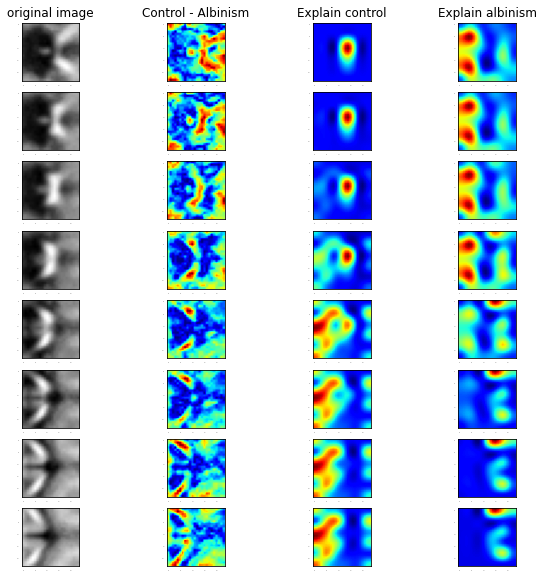

albinism


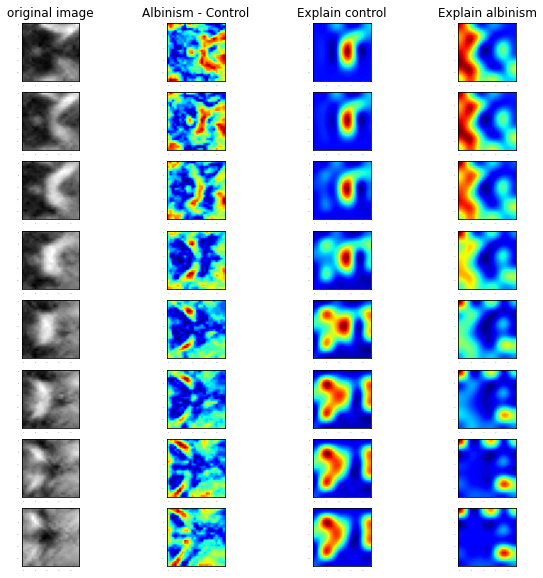

In [32]:
# Fine tune classification + feature extraction GradCAM

# Calculate average input

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:    
    average_control+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==1], axis=(0,1))
    
# Initialize model
model = Classify_chiasm(32,1,0,0)
model.load_state_dict(torch.load('../../1_Data/3_Trained_classifier_finetuning_classification_feature_extraction/32_1_0_0_1e-05_1e-05/optimal_weights'))

# Plots for control
print('Control')

explain_control = model.gradcam(torch.from_numpy(average_control).unsqueeze(0).unsqueeze(0).float(),0)
explain_control = zoom(explain_control,(4,4,4))

explain_albinism = model.gradcam(torch.from_numpy(average_control).unsqueeze(0).unsqueeze(0).float(),1)
explain_albinism = zoom(explain_albinism,(4,4,4))


plt.figure(figsize=(10,10))
for i in range(8):

    # Original image
    plt.subplot(8,4,4*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('original image');
        
    # Show difference
    plt.subplot(8,4,4*i+2)
    plt.imshow(np.abs(average_control[:,:,i]-average_albinism[:,:,i]), cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Control - Albinism');

    # Explain control
    plt.subplot(8,4,4*i+3)
    plt.imshow(explain_control[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain control');
        
    # Explain albinism
    plt.subplot(8,4,4*i+4)
    plt.imshow(explain_albinism[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain albinism');
      
plt.show()
        
# Plots for albinism
print('albinism')

explain_control = model.gradcam(torch.from_numpy(average_albinism).unsqueeze(0).unsqueeze(0).float(),0)
explain_control = zoom(explain_control,(4,4,4))

explain_albinism = model.gradcam(torch.from_numpy(average_albinism).unsqueeze(0).unsqueeze(0).float(),1)
explain_albinism = zoom(explain_albinism,(4,4,4))

plt.figure(figsize=(10,10))
for i in range(8):

    # Original image
    plt.subplot(8,4,4*i+1)
    plt.imshow(average_albinism[:,:,i], cmap='gray', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('original image');

    # Explain control
    plt.subplot(8,4,4*i+2)
    plt.imshow(np.abs(average_albinism[:,:,i]-average_control[:,:,i]), cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Albinism - Control');
    
    # Explain control
    plt.subplot(8,4,4*i+3)
    plt.imshow(explain_control[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain control');
        
    # Explain albinism
    plt.subplot(8,4,4*i+4)
    plt.imshow(explain_albinism[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain albinism');


plt.show()


Control


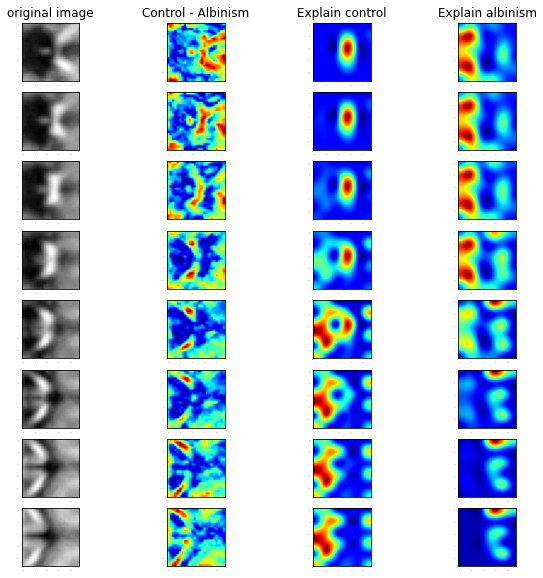

albinism


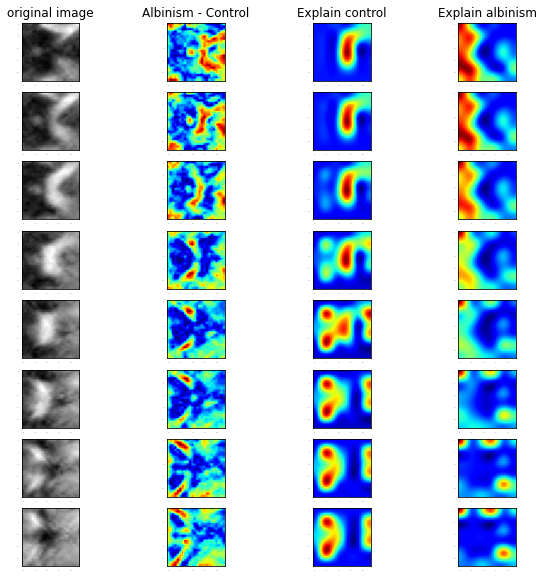

In [33]:
# Random previous GradCAM

# Calculate average input

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:    
    average_control+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==1], axis=(0,1))
    
# Initialize model
model = Classify_chiasm(32,1,0,0)
model.load_state_dict(torch.load('../../1_Data/X_Training_NLLLoss/3_Trained_classifier_fc_layer_only/32_1_0_0_1e-05/optimal_weights'))


# Plots for control
print('Control')

explain_control = model.gradcam(torch.from_numpy(average_control).unsqueeze(0).unsqueeze(0).float(),0)
explain_control = zoom(explain_control,(4,4,4))

explain_albinism = model.gradcam(torch.from_numpy(average_control).unsqueeze(0).unsqueeze(0).float(),1)
explain_albinism = zoom(explain_albinism,(4,4,4))


plt.figure(figsize=(10,10))
for i in range(8):

    # Original image
    plt.subplot(8,4,4*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('original image');
        
    # Show difference
    plt.subplot(8,4,4*i+2)
    plt.imshow(np.abs(average_control[:,:,i]-average_albinism[:,:,i]), cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Control - Albinism');

    # Explain control
    plt.subplot(8,4,4*i+3)
    plt.imshow(explain_control[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain control');
        
    # Explain albinism
    plt.subplot(8,4,4*i+4)
    plt.imshow(explain_albinism[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain albinism');
      
plt.show()
        
# Plots for albinism
print('albinism')

explain_control = model.gradcam(torch.from_numpy(average_albinism).unsqueeze(0).unsqueeze(0).float(),0)
explain_control = zoom(explain_control,(4,4,4))

explain_albinism = model.gradcam(torch.from_numpy(average_albinism).unsqueeze(0).unsqueeze(0).float(),1)
explain_albinism = zoom(explain_albinism,(4,4,4))

plt.figure(figsize=(10,10))
for i in range(8):

    # Original image
    plt.subplot(8,4,4*i+1)
    plt.imshow(average_albinism[:,:,i], cmap='gray', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('original image');

    # Explain control
    plt.subplot(8,4,4*i+2)
    plt.imshow(np.abs(average_albinism[:,:,i]-average_control[:,:,i]), cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Albinism - Control');
    
    # Explain control
    plt.subplot(8,4,4*i+3)
    plt.imshow(explain_control[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain control');
        
    # Explain albinism
    plt.subplot(8,4,4*i+4)
    plt.imshow(explain_albinism[:,:,i], cmap='jet', alpha=1)    
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Explain albinism');


plt.show()


# Explanations with captum

## Showcase on CIFAR

In [215]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import visualization as viz

In [172]:
# Works beautifully!
model = Classify_chiasm(32,1,0,0)
model.load_state_dict(torch.load('../../1_Data/3_Trained_classifier_full_retraining/32_1_0_0_1e-06/optimal_weights'))

<All keys matched successfully>

In [173]:
for batch in dataloaders_chiasm['dev_test']:
    print('Works')

Works


In [174]:
# Atribution algorithms on chosen input
ind=0

input = batch['chiasm']['data'][ind].unsqueeze(0)
input.requires_grad = True

In [175]:
# Set model in evaluation mode
model.eval();

In [176]:
# My GradCAM

attr_gradcam = model.gradcam(input.float(),0)
attr_gradcam = zoom(attr_gradcam,(4,4,4))

In [177]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [178]:
# computes gradients with respect to target class and transposes them for visualization purposes.
saliency = Saliency(model)
grads = saliency.attribute(input, target=labels[ind].item())

In [179]:
# Applies integrated gradients attribution algorithm on test image. Integrated Gradients computes the integral of the gradients of the output prediction for the class index ind with respect to the input image pixels. More details about integrated gradients can be found in the original paper
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0101], dtype=torch.float64)


In [180]:
# Below we demonstrate how to use integrated gradients and noise tunnel with smoothgrad square option on the test image. Noise tunnel with smoothgrad square option adds gaussian noise with a standard deviation of stdevs=0.2 to the input image nt_samples times, computes the attributions for nt_samples images and returns the mean of the squared attributions across nt_samples images.
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)

In [181]:
# Applies DeepLift on test image. Deeplift assigns attributions to each input pixel by looking at the differences of output and its reference in terms of the differences of the input from the reference.
dl = DeepLift(model)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)

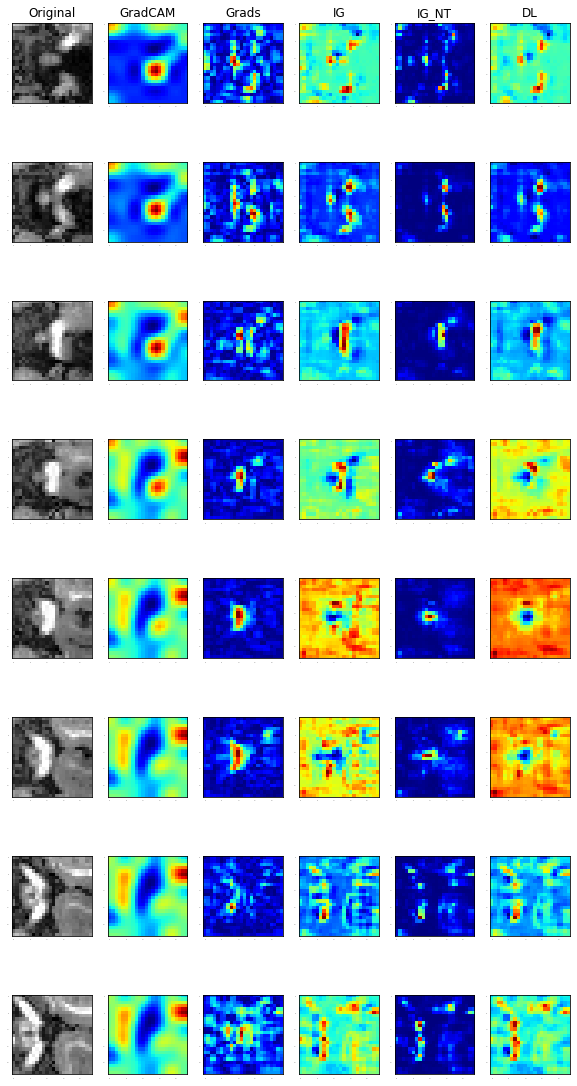

In [182]:
fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],6,6*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
        
    plt.subplot(input.shape[4],6,6*i+2)
    plt.imshow(attr_gradcam[:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('GradCAM')
    
    plt.subplot(input.shape[4],6,6*i+3)
    plt.imshow(grads.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Grads')
    
    plt.subplot(input.shape[4],6,6*i+4)
    plt.imshow(attr_ig.detach().numpy()[0,0,:,:,i],cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG')
        
    plt.subplot(input.shape[4],6,6*i+5)
    plt.imshow(attr_ig_nt.detach().numpy()[0,0,:,:,i],cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG_NT')
    
    plt.subplot(input.shape[4],6,6*i+6)
    plt.imshow(attr_dl.detach().numpy()[0,0,:,:,i],cmap='jet')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('DL')


## Pretrained ResNet model

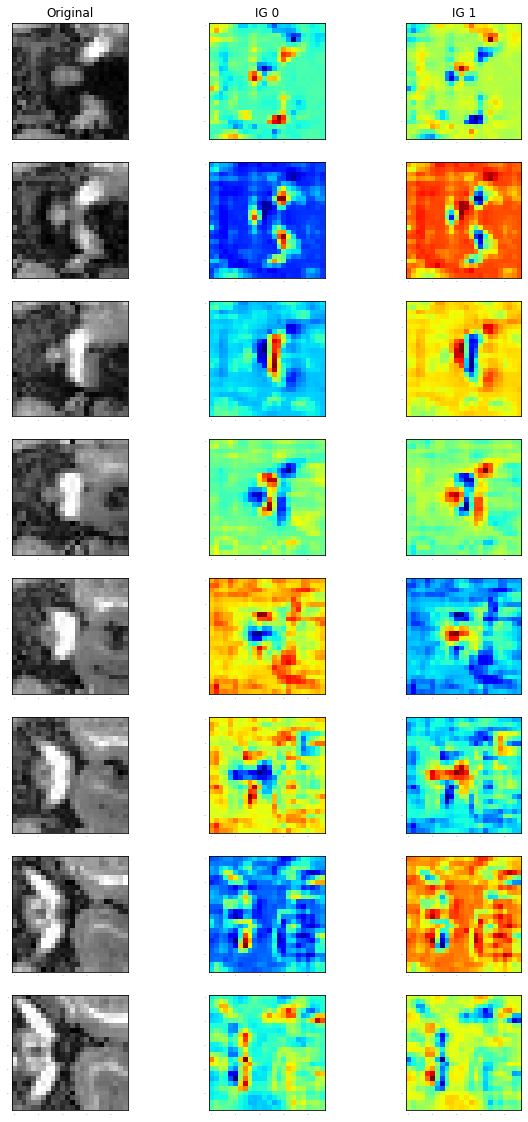

In [197]:
# Integrated gradients
integrated_gradients = IntegratedGradients(model)
attributions_ig_zero = integrated_gradients.attribute(input, target=0, n_steps=200)
attributions_ig_one = integrated_gradients.attribute(input, target=1, n_steps=200)

fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],3,3*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
        
    plt.subplot(input.shape[4],3,3*i+2)
    plt.imshow(attributions_ig_zero.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG 0')
        
    plt.subplot(input.shape[4],3,3*i+3)
    plt.imshow(attributions_ig_one.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG 1')

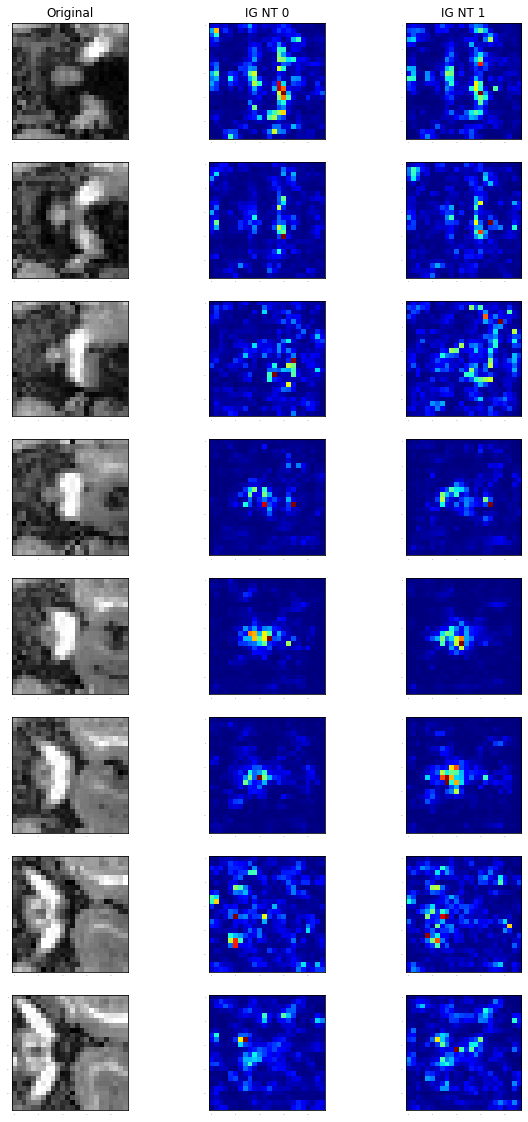

In [208]:
# IG + Noise Tunnel
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt_zero = noise_tunnel.attribute(input, nt_samples=20, nt_type='smoothgrad_sq', target=0)
attributions_ig_nt_one = noise_tunnel.attribute(input, nt_samples=20, nt_type='smoothgrad_sq', target=1)

fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],3,3*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
        
    plt.subplot(input.shape[4],3,3*i+2)
    plt.imshow(attributions_ig_nt_zero.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG NT 0')
        
    plt.subplot(input.shape[4],3,3*i+3)
    plt.imshow(attributions_ig_nt_one.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('IG NT 1')

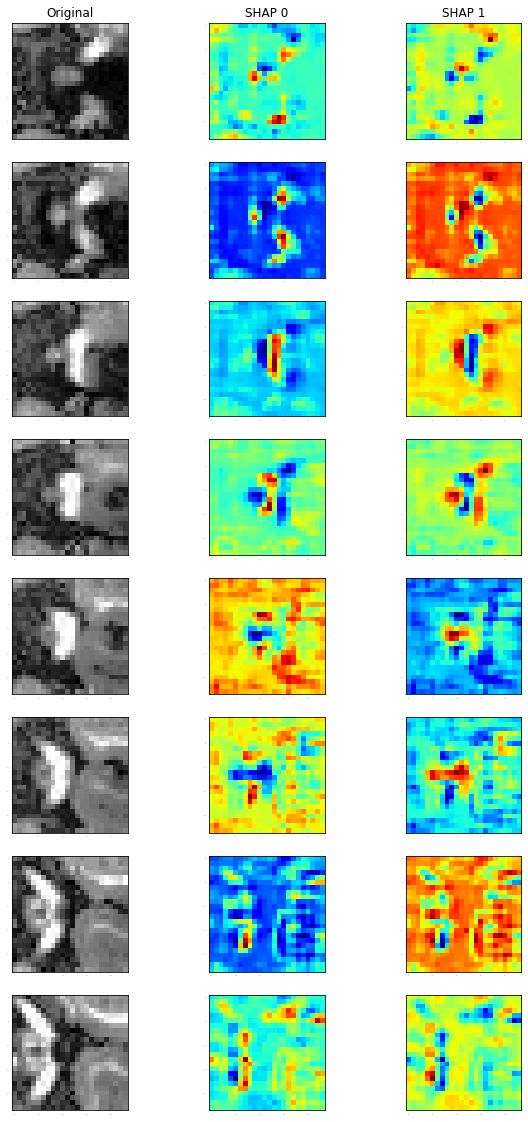

In [214]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs_zero = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=0)

attributions_gs_one = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=1)

fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],3,3*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
        
    plt.subplot(input.shape[4],3,3*i+2)
    plt.imshow(attributions_gs_zero.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('SHAP 0')
        
    plt.subplot(input.shape[4],3,3*i+3)
    plt.imshow(attributions_gs_one.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('SHAP 1')

In [244]:
# Occlusion
occlusion = Occlusion(model)

attributions_occ_zero = occlusion.attribute(input,
                                       target=0,
                                       sliding_window_shapes=(1,2,2,1),
                                       baselines=0)


attributions_occ_one = occlusion.attribute(input,
                                       target=1,
                                       sliding_window_shapes=(1,2,2,1),
                                       baselines=0)

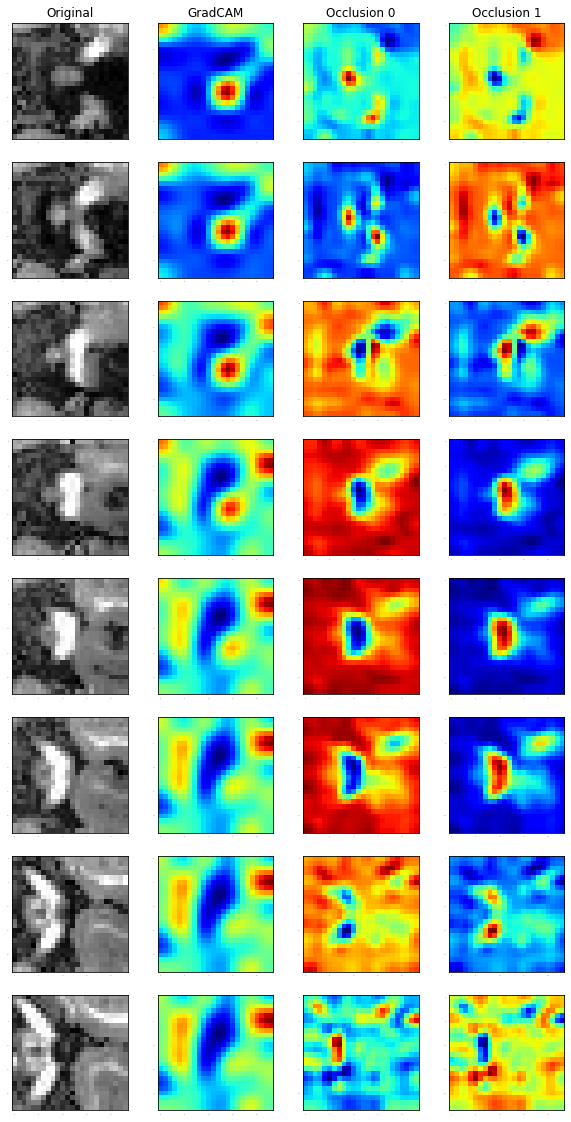

In [245]:
fig=plt.figure(figsize=(10,20))
for i in range(input.shape[4]):
    
    plt.subplot(input.shape[4],4,4*i+1)
    plt.imshow(input.detach()[0,0,:,:,i],cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Original')
        
    plt.subplot(input.shape[4],4,4*i+2)
    plt.imshow(attr_gradcam[:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('GradCAM')
        
    plt.subplot(input.shape[4],4,4*i+3)
    plt.imshow(attributions_occ_zero.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Occlusion 0')
        
    plt.subplot(input.shape[4],4,4*i+4)
    plt.imshow(attributions_occ_one.detach().numpy()[0,0,:,:,i],cmap='jet',alpha=1)
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if i==0:
        plt.title('Occlusion 1')